<a href="https://colab.research.google.com/github/YasaminAbbaszadegan/News_Summarizer_using_Llama2_Qlora/blob/main/Summarizer_Inference_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7
!pip install bert_score
!pip install rouge_score

In [ ]:
import subprocess

def get_gpu_usage():
    try:
        result = subprocess.run(
            ['nvidia-smi'],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        print(result.stdout)
    except FileNotFoundError as e:
        print("nvidia-smi not found. Ensure NVIDIA drivers are installed and nvidia-smi is in your PATH.")

get_gpu_usage()

Wed May 15 21:27:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Prepare Initial Functions

In [ ]:
import pandas as pd
import numpy as np
import random
from datasets import Dataset, load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments
import warnings
import torch
import pandas as pd
import numpy as np
import random
from datasets import Dataset, load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments
import warnings
from peft import AutoPeftModelForCausalLM
from trl import SFTTrainer
from peft import LoraConfig, get_peft_model,PeftModel
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)
from peft import prepare_model_for_kbit_training

warnings.filterwarnings("ignore")

def load_and_preprocess_dataset(huggingface_dataset_name="cnn_dailymail"):
    dataset = load_dataset(huggingface_dataset_name, "3.0.0")

    def format_instruction(dialogue: str, summary: str):
        return f"""### Instruction:
        Summarize the following conversation.
        ​
        ### Input:
        {dialogue.strip()}
        ​
        ### Summary:
        {summary}
        """.strip()

    def generate_instruction_dataset(data_point):
        return {
            "article": data_point["article"],
            "highlights": data_point["highlights"],
            "text": format_instruction(data_point["article"],data_point["highlights"])
        }

    def process_dataset(data: Dataset):
        return (
            data.shuffle(seed=42)
            .map(generate_instruction_dataset)
            .remove_columns(['id'])
        )

    dataset["train"] = process_dataset(dataset["train"])
    dataset["test"] = process_dataset(dataset["validation"])
    dataset["validation"] = process_dataset(dataset["validation"])

    train_data = dataset['train'].shuffle(seed=42).select([i for i in range(500)]) #1000
    test_data = dataset['test'].shuffle(seed=42).select([i for i in range(100)])
    validation_data = dataset['validation'].shuffle(seed=42).select([i for i in range(100)])

    return train_data, test_data, validation_data



def load_model_and_tokenizer(lora_config,model_id="NousResearch/Llama-2-7b-hf"):

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

    model = AutoModelForCausalLM.from_pretrained(model_id,
                                                 quantization_config=bnb_config,
                                                 use_safetensors=True,
                                                 device_map="auto")
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    model.gradient_checkpointing_enable()
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, lora_config)
    print(model)
    return model, tokenizer



def generate_summary(trained_model, tokenizer, dialogue):
    prompt = f"""
    ### Instruction:
    Summarize the following News Article.
    ​
    ### Input:
    {dialogue}
    ​
    ### Summary:
    """.strip()
    input_ids = tokenizer(prompt, return_tensors='pt',truncation=True).input_ids.cuda()
    outputs = trained_model.generate(input_ids=input_ids, max_new_tokens=200, )
    output = tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]

    return output

train_data, test_data, validation_data = load_and_preprocess_dataset()


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

# Load Qlora fine tuned CNN Summarizer

In [ ]:
from peft import PeftConfig, PeftModel
PEFT_MODEL = "YasaminAbb/Llama-2-7b-CNN_Q_lora_Summarizer"
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        load_in_8bit_fp32_cpu_offload=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )
config = PeftConfig.from_pretrained(PEFT_MODEL)
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] == 8 else torch.float16
"""
If the CUDA device is of a newer architecture (Volta or newer), it uses torch.bfloat16 for potentially better performance
or memory efficiency, otherwise, it falls back to torch.float16.
"""

model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto" , #"auto",
    torch_dtype=dtype,
    trust_remote_code=True,
         load_in_8bit=True
)
tokenizer_mine = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
tokenizer_mine.pad_token = tokenizer_mine.eos_token

model_mine = PeftModel.from_pretrained(model, PEFT_MODEL)

adapter_config.json:   0%|          | 0.00/475 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

adapter_model.bin:   0%|          | 0.00/33.6M [00:00<?, ?B/s]


# Metric calculations

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
import pandas as pd
from datasets import load_metric
from statistics import mean
from bert_score import BERTScorer

# Load BLEU and ROUGE metrics
bleu_metric = load_metric('bleu')
rouge_metric = load_metric('rouge')

# Initialize lists to store evaluation results
patent_nos, bleu, b_prec, b_rec, b_f1, candidates, grounds = [], [], [], [], [], [], []
rouges = {'rouge1': [], 'rouge2': [], 'rougeL': []}

def calc_rouges(rouge_scores, rouge_type):
    rouge_h = rouge_scores[rouge_type].high.fmeasure
    rouge_m = rouge_scores[rouge_type].mid.fmeasure
    rouge_l = rouge_scores[rouge_type].low.fmeasure
    return mean([rouge_h, rouge_m, rouge_l])

def make_predictions(sentence_pairs):
    for sentence_pair in sentence_pairs:
        candidate = sentence_pair['candidate']
        ground1 = sentence_pair['ground1']

        # Compute BLEU score
        bleu_scores = bleu_metric.compute(predictions=[candidate.split(' ')], references=[[ground1.split(' ')]])
        bleu.append(bleu_scores['precisions'][0])

        # Compute ROUGE score
        rouge_scores =  rouge_metric.compute(predictions=[candidate], references=[ground1])
        for rouge_type, results in rouges.items():
            rouges[rouge_type].append(calc_rouges(rouge_scores, rouge_type))

        # Compute BERT_score
        P, R, F1 = bertscore_metric.score([candidate], [ground1])
        candidates.append(candidate)
        grounds.append(ground1)
        b_prec.append(P.item())
        b_rec.append(R.item())
        b_f1.append(F1.item())

    # Create a DataFrame from the collected data
    df_dict = {
        "candidates": candidates,
        "grounds": grounds,
        "b_prec": b_prec,
        "b_rec": b_rec,
        "b_f1": b_f1,
        "bleu": bleu,
    }
    df_dict.update(rouges)
    return pd.DataFrame(df_dict)


# Inference

In [ ]:
from tqdm import tqdm
import time
import nltk
nltk.download('punkt')


results = []
inference_latencies=[]
for idx,sample in enumerate(test_data):
    dialogue = test_data['article'][idx][:10000]
    summary = test_data['highlights'][idx]
    start_time = time.time()
    generated_summary = generate_summary(model_mine, tokenizer_mine, dialogue)
    end_time = time.time()
    latency = end_time - start_time
    inference_latencies.append(latency)

    results.append({
        'index': idx,
        'dialogue': dialogue,
        'summary': summary,
        'generated_summary': generated_summary
    })

    dash_line = '-' * 100
    print(dash_line)
    print(f'INPUT dialogue:\n{dialogue}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
    print(dash_line)
    print(f'TRAINED MODEL GENERATED TEXT:\n{generated_summary}')

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)
results_df['token_len']=results_df['dialogue'].apply(lambda x: len(nltk.word_tokenize(x)))

results_df['inference_latencies']=inference_latencies


# Inference Latency

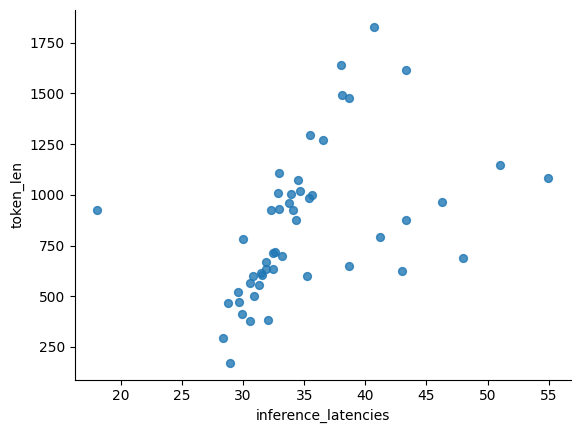

In [ ]:
# @title token_len vs inference_latencies

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='inference_latencies', y='token_len', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

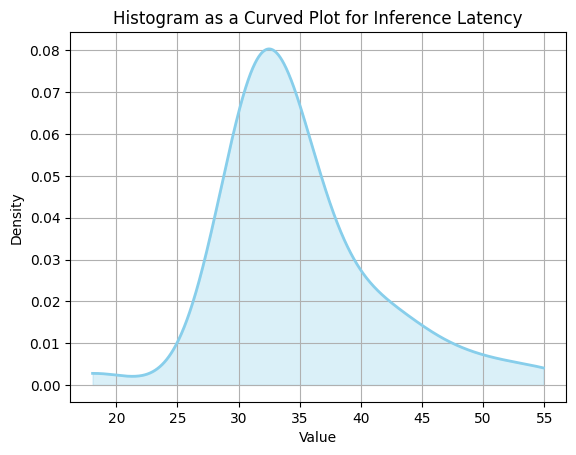

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate some random data (replace this with your array of numbers)
data = inference_latencies

# Create KDE object
kde = gaussian_kde(data)

# Generate data for the KDE plot
x_vals = np.linspace(min(data), max(data), 1000)
y_vals = kde(x_vals)

# Plot histogram
plt.plot(x_vals, y_vals, color='skyblue', lw=2)
plt.fill_between(x_vals, y_vals, color='skyblue', alpha=0.3)

plt.title('Histogram as a Curved Plot for Inference Latency')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

# Calculate average inference latency using numpy
average_latency = np.mean(inference_latencies)
print(f'Average Inference Latency: {average_latency} seconds')

Average Inference Latency: 34.938194127082824 seconds


# Test set Metric Scores

In [ ]:
import regex as re

def clean_text(text):
  text=text.replace('\n','')
  text = re.sub(r'\s+', ' ', text)
  return text

sentence_pairs = [{'candidate': clean_text(summary), 'ground1': clean_text(generated_summary)} for summary, generated_summary in zip(results_df['summary'], results_df['generated_summary'])]

# Load BLEU and BERT_score metrics
bertscore_metric = BERTScorer(lang="en")
df_not_rescaled = make_predictions(sentence_pairs)
df_not_rescaled

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,candidates,grounds,b_prec,b_rec,b_f1,bleu,rouge1,rouge2,rougeL
0,Scrapping Britain's Trident nuclear deterrent ...,Nicola Sturgeon said the SNP would still be p...,0.886941,0.854972,0.870663,0.532258,0.380000,0.121212,0.220000
1,Shaneka Monique Torres went on trial after rej...,"Shaneka Monique Torres, 30, is accused of fir...",0.898777,0.867686,0.882958,0.563218,0.472103,0.207792,0.257511
2,"Suki, 23, and musician George star in Burberry...",​ Suki Waterhouse gets up close and personal ...,0.895817,0.833718,0.863653,0.580645,0.253165,0.115385,0.189873
3,Rebecca Cross was filmed picking up five-year-...,Crufts has become embroiled in a second contr...,0.876527,0.853817,0.865023,0.455882,0.378641,0.088235,0.145631
4,Lawyers for Cecil Clayton are seeking a compet...,"Cecil Clayton, 68, will be executed at the st...",0.864986,0.863287,0.864136,0.333333,0.343891,0.073059,0.153846
5,Whale with no flukes was seen off coast of Sou...,"The migrating gray whale, whose tail was like...",0.872878,0.855232,0.863965,0.366197,0.298077,0.097087,0.163462
6,In celebration of International Women's Day we...,All of these women left a mark on the world t...,0.820238,0.783767,0.801588,0.181818,0.105960,0.013423,0.092715
7,Jorge Pereira won the amateur prize at the Wor...,​ Jorge Pereira won the open savoury amateur ...,0.910317,0.843754,0.875772,0.636364,0.335570,0.176871,0.228188
8,Amnesty International says Arab state has behe...,Saudi Arabia has executed 38 people so far th...,0.894682,0.840216,0.866594,0.553191,0.339394,0.171779,0.266667
9,The new two-seater Aston Martin Vulcan will se...,Aston Martin Vulcan will be unveiled at the G...,0.818333,0.803864,0.811034,0.352941,0.150289,0.035088,0.127168


In [ ]:

# Ensure the specified columns are numeric
columns = ['b_prec', 'b_rec', 'b_f1', 'bleu', 'rouge1', 'rouge2', 'rougeL']
results_mean={}
for column in columns:
  results_mean[column]=df_not_rescaled[column].mean()
results_mean

{'b_prec': 0.8871946907043458,
 'b_rec': 0.8528983092308045,
 'b_f1': 0.8695924198627472,
 'bleu': 0.4956033495352355,
 'rouge1': 0.336562851964106,
 'rouge2': 0.14376855789110538,
 'rougeL': 0.21841933041957584}

In [ ]:
len(sentence_pairs)

50

#Handler for API

In [ ]:
#https://www.mlexpert.io/blog/deploy-llm-to-production
from typing import Any, Dict
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftConfig, PeftModel

class EndpointHandler:
  def __init__(self,path=""):
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        load_in_8bit_fp32_cpu_offload=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )
    config = PeftConfig.from_pretrained(path)
    dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] == 8 else torch.float16
    model = AutoModelForCausalLM.from_pretrained(
                                              config.base_model_name_or_path,
                                              return_dict=True,
                                              quantization_config=bnb_config,
                                              device_map="auto" , #"auto",
                                              torch_dtype=dtype,
                                              trust_remote_code=True,
                                                  load_in_8bit=True
                                              )
    tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
    tokenizer.pad_token = tokenizer.eos_token
    self.tokenizer=tokenizer

    self.model = PeftModel.from_pretrained(model, path)


  def __call__(self, data: Dict[str, Any]) -> Dict[str, Any]:
      prompt = data.pop("inputs", data)
      prompt = f"""
      ### Instruction:
      Summarize the following News Article.
      ​
      ### Input:
      {prompt}
      ​
      ### Summary:
      """.strip()
      input_ids = self.tokenizer(prompt, return_tensors='pt',truncation=True).input_ids.cuda()
      outputs = self.model.generate(input_ids=input_ids, max_new_tokens=200, )
      output = self.tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]
      return output

### Demo on how the Handler API work

In [ ]:
MODEL_ID = "YasaminAbb/Llama-2-7b-CNN_Q_lora_Summarizer"
my_handler = EndpointHandler(path=MODEL_ID)

prompt = """
By . Snejana Farberov . PUBLISHED: . 18:33 EST, 25 April 2013 . | . UPDATED: . 18:33 EST, 25 April 2013 .
Jacqueline Whylly, of Minnesota, experienced any parent’s worst nightmare this week when she was told that her
toddler son was left behind on a field trip. Whylly’s son, 4-year-old AJ, was taken with his classmates to visit
the Children's Museum of South Dakota in Brookings Tuesday. Teachers didn't realize the toddler, who has speech impediment issues,
was missing until they were back in Marshall, about an hour away. Left behind: AJ, age four, pictured right with his family,
was abandoned while on a school trip to a South Dakota museum, and no one realized the boy was not on the bus until an hour later .
Mom outraged: Jacqueline Whylly, the boy's mother, said her son was neglected, and no one was responsible for him .
The boy’s mother said no one was accountable for her son. 'Anyone could have took [sic] him,
' Whylly said. 'He was neglected and alone.' To . add insult to injury, Whylly said she had offered her son's school .
officials to accompany the students on the trip, but was told that they . had enough adults. Marshall Superintendent Klint Willert .
offered his ‘sincere apologies’ to the mother and son when he talked to KARE-TV and said rules for field trips were not followed.
He said students are to be counted before they get on the bus and again after they've boarded, which apparently did not happen.
A meeting with district administrators was expected to take place Thursday morning to review field trip procedures.
Trip gone awry: AJ and his classmates were visiting the Children's Museum of South Dakota when the boy was left behind .
Long way to go: School officials did not realize the 4-year-old was not on the bus until they arrived back in Marshall, Minnesota,
63 miles away from the museum, about an hour later . Willert also said that the teacher who was chaperoning the field trip will
be disciplined for failing to count the students on the bus. Meanwhile, Whylly said she will keep her son home until she is satisfied that changes are being made.

""".strip()

payload = {"inputs": prompt}
prediction = my_handler(payload)
print(prediction)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(



      AJ Whylly, 4, was left behind on a school trip to the Children's Museum of South Dakota .
Mother Jacqueline Whylly said no one was responsible for her son .
School officials said they did not count the students on the bus .
The boy's mother said she offered to accompany her son on the trip, but was told that they had enough adults .
The boy's mother said she will keep her son home until she is satisfied that changes are being made .
AJ Whylly, 4, was left behind on a school trip to the Children's Museum of South Dakota in Brookings, about an hour away from his school in Marshall, Minnesota. School officials did not realize the boy was not on the bus until they arrived back in Marshall, 63 miles away from the museum. Meanwhile, Whylly said she will keep her son home until she is satisfied


In [ ]:
import torch
import locale

print(torch.__version__)

locale.getpreferredencoding = lambda: "UTF-8"
!pip freeze > requirements.txt

2.2.1+cu121


### Demo on how the Handler API work using Huggingface APIs

In [ ]:
import requests
API_URL = ""
API_TOKEN = ""
headers = {"Authorization": f"Bearer {API_TOKEN}"}

prompt = """
By . Snejana Farberov . PUBLISHED: . 18:33 EST, 25 April 2013 . | . UPDATED: . 18:33 EST, 25 April 2013 .
Jacqueline Whylly, of Minnesota, experienced any parent’s worst nightmare this week when she was told that her
toddler son was left behind on a field trip. Whylly’s son, 4-year-old AJ, was taken with his classmates to visit
the Children's Museum of South Dakota in Brookings Tuesday. Teachers didn't realize the toddler, who has speech impediment issues,
was missing until they were back in Marshall, about an hour away. Left behind: AJ, age four, pictured right with his family,
was abandoned while on a school trip to a South Dakota museum, and no one realized the boy was not on the bus until an hour later .
Mom outraged: Jacqueline Whylly, the boy's mother, said her son was neglected, and no one was responsible for him .
The boy’s mother said no one was accountable for her son. 'Anyone could have took [sic] him,
' Whylly said. 'He was neglected and alone.' To . add insult to injury, Whylly said she had offered her son's school .
officials to accompany the students on the trip, but was told that they . had enough adults. Marshall Superintendent Klint Willert .
offered his ‘sincere apologies’ to the mother and son when he talked to KARE-TV and said rules for field trips were not followed.
He said students are to be counted before they get on the bus and again after they've boarded, which apparently did not happen.
A meeting with district administrators was expected to take place Thursday morning to review field trip procedures.
Trip gone awry: AJ and his classmates were visiting the Children's Museum of South Dakota when the boy was left behind .
Long way to go: School officials did not realize the 4-year-old was not on the bus until they arrived back in Marshall, Minnesota,
63 miles away from the museum, about an hour later . Willert also said that the teacher who was chaperoning the field trip will
be disciplined for failing to count the students on the bus. Meanwhile, Whylly said she will keep her son home until she is satisfied that changes are being made.

""".strip()

payload = {"inputs": prompt}
response = requests.post(API_URL, json=payload, headers=headers)
response = response.json()
print(response)




      AJ Whylly, 4, was left behind on a school trip to the Children's Museum of South Dakota .
Mother Jacqueline Whylly said no one was responsible for her son .
School officials said they did not count the students on the bus .
The boy's mother said she offered to accompany her son on the trip, but was told that they had enough adults .
The boy's mother said she will keep her son home until she is satisfied that changes are being made .
AJ Whylly, 4, was left behind on a school trip to the Children's Museum of South Dakota in Brookings.
The boy's mother, Jacqueline Whylly, said no one was responsible for her son.
'Anyone could have took [sic] him,' Whylly said. 'He was neglected and alone.'
School officials said they did

